# 用期現貨籌碼預測隔天漲跌

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    roc_curve,
    # accuracy_score,precision_score,recall_score,confusion_matrix,precision_recall_curve,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.tree import export_graphviz  # , DecisionTreeClassifier
from six import StringIO
from IPython.display import Image
import pydotplus


# 檢查資料是否有異常值

In [7]:
df = pd.read_csv("./raw_data.csv", index_col="date", parse_dates=True,)[
    [
        "inst_f buy",
        "inst_t buy",
        "inst_txf_net",
        "inst_txf_oi",
        "inst_mtx_net",
        "inst_mtx_oi",
        "txf_open",
        "txf_high",
        "txf_low",
        "txf_close",
        "txf_volume",
    ]
]
print(f"資料有{df.shape[0]}個rows、{df.shape[1]}個columns")
display(df.info())
df.tail()


資料有655個rows、11個columns
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 655 entries, 2019-01-02 to 2021-09-10
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   inst_f buy    655 non-null    int64
 1   inst_t buy    655 non-null    int64
 2   inst_txf_net  655 non-null    int64
 3   inst_txf_oi   655 non-null    int64
 4   inst_mtx_net  655 non-null    int64
 5   inst_mtx_oi   655 non-null    int64
 6   txf_open      655 non-null    int64
 7   txf_high      655 non-null    int64
 8   txf_low       655 non-null    int64
 9   txf_close     655 non-null    int64
 10  txf_volume    655 non-null    int64
dtypes: int64(11)
memory usage: 61.4 KB


None

,inst_f buy,inst_t buy,inst_txf_net,inst_txf_oi,inst_mtx_net,inst_mtx_oi,txf_open,txf_high,txf_low,txf_close,txf_volume
date,,,,,,,,,,,
2021-09-06,7666042064,-1252559575,3523,-16296,734,4144,17440,17596,17425,17493,118794
2021-09-07,6690800894,-1488392384,715,-15580,-318,3822,17522,17529,17337,17424,125058
2021-09-08,-1072311064,-434523230,1383,-14197,-447,3366,17395,17426,17163,17260,151432
2021-09-09,-637610085,337589613,1043,-11655,-1457,-4087,17142,17291,17084,17238,124510
2021-09-10,14973318520,457382200,-2651,-14302,2767,-1336,17300,17479,17284,17473,108107


In [ ]:
# df = df.rename(
#     columns={
#         "inst_f buy": "外資現股買賣超",
#         "inst_t buy": "投信現股買賣超",
#         "inst_txf_net": "外資大台多空淨額",
#         "inst_txf_oi": "外資大台未平倉",
#         "inst_mtx_net": "外資小台多空淨額",
#         "inst_mtx_oi": "外資小台未平倉",
#         "txf_open": "台指期_開盤價",
#         "txf_high": "台指期_最高價",
#         "txf_low": "台指期_最低價",
#         "txf_close": "台指期_收盤價",
#         "txf_volume": "台指期_成交量",
#     }
# )
# df.tail()


# 定義特徵值為隔天是收紅K或黑K

In [8]:
df = df.assign(label=df["txf_close"].shift(-1) - df["txf_open"].shift(-1))
df = df[:-1]
df.tail()


,inst_f buy,inst_t buy,inst_txf_net,inst_txf_oi,inst_mtx_net,inst_mtx_oi,txf_open,txf_high,txf_low,txf_close,txf_volume,label
date,,,,,,,,,,,,
2021-09-03,32088019893,864496798,-4014,-19816,2006,3398,17442,17553,17370,17508,114052,53.0
2021-09-06,7666042064,-1252559575,3523,-16296,734,4144,17440,17596,17425,17493,118794,-98.0
2021-09-07,6690800894,-1488392384,715,-15580,-318,3822,17522,17529,17337,17424,125058,-135.0
2021-09-08,-1072311064,-434523230,1383,-14197,-447,3366,17395,17426,17163,17260,151432,96.0
2021-09-09,-637610085,337589613,1043,-11655,-1457,-4087,17142,17291,17084,17238,124510,173.0


# 檢查K棒份佈，最慘曾大跌806，最好曾大漲584

count    654.000000
mean       2.178899
std      110.674156
min     -806.000000
25%      -45.000000
50%        4.000000
75%       56.000000
max      584.000000
Name: label, dtype: float64

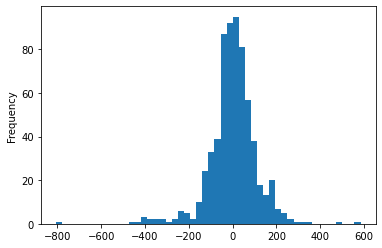

In [9]:
df['label'].plot.hist(bins= 50)
df['label'].describe()

# 新增一欄為紅Kv黑K，分群看兩種K棒對應的籌碼長怎樣

In [10]:
df["rise_decline"] = np.where(df["label"] >= 0, 1, 0)
raise_decline = df.groupby('rise_decline')
display(raise_decline.mean())
len(df[df['rise_decline'] == 0]),len(df[df['rise_decline'] == 1]) 

,inst_f buy,inst_t buy,inst_txf_net,inst_txf_oi,inst_mtx_net,inst_mtx_oi,txf_open,txf_high,txf_low,txf_close,txf_volume,label
rise_decline,,,,,,,,,,,,
0,-1.640366e+09,7.951907e+07,-174.154839,19806.751613,-620.806452,-671.796774,13005.241935,13075.725806,12924.470968,13006.483871,115840.635484,-76.654839
1,-7.011505e+08,1.403255e+08,227.308140,25177.968023,2.613372,-627.936047,12533.281977,12608.188953,12451.639535,12535.130814,116392.979651,73.220930


(310, 344)

,inst_f buy,inst_t buy,inst_txf_net,inst_txf_oi,inst_mtx_net,inst_mtx_oi
inst_f buy,1.000000,0.040443,-0.000788,0.130222,0.439982,0.469436
inst_t buy,0.040443,1.000000,0.074203,0.019976,0.138984,0.159342
inst_txf_net,-0.000788,0.074203,1.000000,0.076473,0.591689,0.253232
inst_txf_oi,0.130222,0.019976,0.076473,1.000000,0.057333,0.174872
inst_mtx_net,0.439982,0.138984,0.591689,0.057333,1.000000,0.521047
inst_mtx_oi,0.469436,0.159342,0.253232,0.174872,0.521047,1.000000


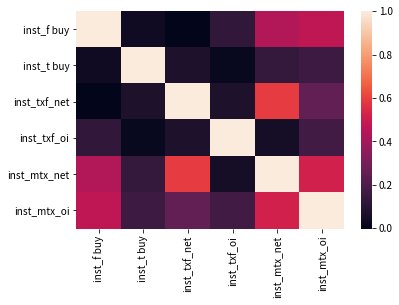

In [12]:
# plt.rcParams["font.sans-serif"] = ["Noto Sans CJK TC"]
heatmap = df.iloc[:, :6].corr()
sns.heatmap(heatmap, xticklabels=heatmap.columns[:6], yticklabels=heatmap.columns[:6])
heatmap

In [13]:
degree_freedom = len(df[df['rise_decline'] == 1])
LQ = stats.t.ppf(0.025, degree_freedom)
RQ = stats.t.ppf(0.975, degree_freedom)
print(f'在95％信賴區間下，t分佈左邊界 {LQ:.3}，右邊界 {RQ:.3}')

在95％信賴區間下，t分佈左邊界 -1.97，右邊界 1.97


# 概率分佈 Probability distribution
# 概率函數 Probability Dense Function

Text(0.5, 1.0, '嗯')

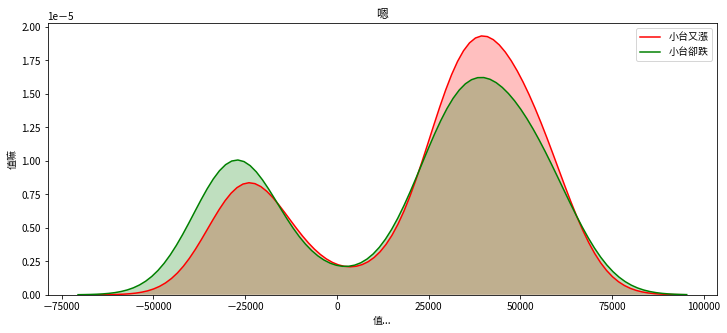

In [14]:
param = "inst_txf_oi"

fig = plt.figure(figsize=(12, 5))
ax = sns.kdeplot(
    df.loc[(df["rise_decline"] == 1), param],
    color="r",
    shade=True,
    label="小台又漲",
)
ax = sns.kdeplot(
    df.loc[(df["rise_decline"] == 0), param],
    color="g",
    shade=True,
    label="小台卻跌",
)
ax.set(xlabel="值...", ylabel="值嘛")
plt.title("嗯")


In [16]:
# df['轉出的新欄'] = df['字串class欄'].astype('category').cat.codes
X = df.iloc[:, :6]
y = df["rise_decline"]
X_train, X_test, y_train, y_test = train_test_split(
    # straifity表示 y為True的百分比與raw data一致
    X,
    y,
    test_size=0.15,
    random_state=78,
    stratify=y,
)


In [17]:
dtree = tree.DecisionTreeClassifier(
    criterion="entropy",
    # 葉節點至少需要多少百分比
    min_weight_fraction_leaf=0.01,
)
dtree = dtree.fit(X_train, y_train)
dt_roc_auc = roc_auc_score(y_test, dtree.predict(X_test))
print(f"決策樹 AUC = {dt_roc_auc:.3}")
print(classification_report(y_test, dtree.predict(X_test)))


決策樹 AUC = 0.516
              precision    recall  f1-score   support

           0       0.49      0.53      0.51        47
           1       0.54      0.50      0.52        52

    accuracy                           0.52        99
   macro avg       0.52      0.52      0.52        99
weighted avg       0.52      0.52      0.52        99



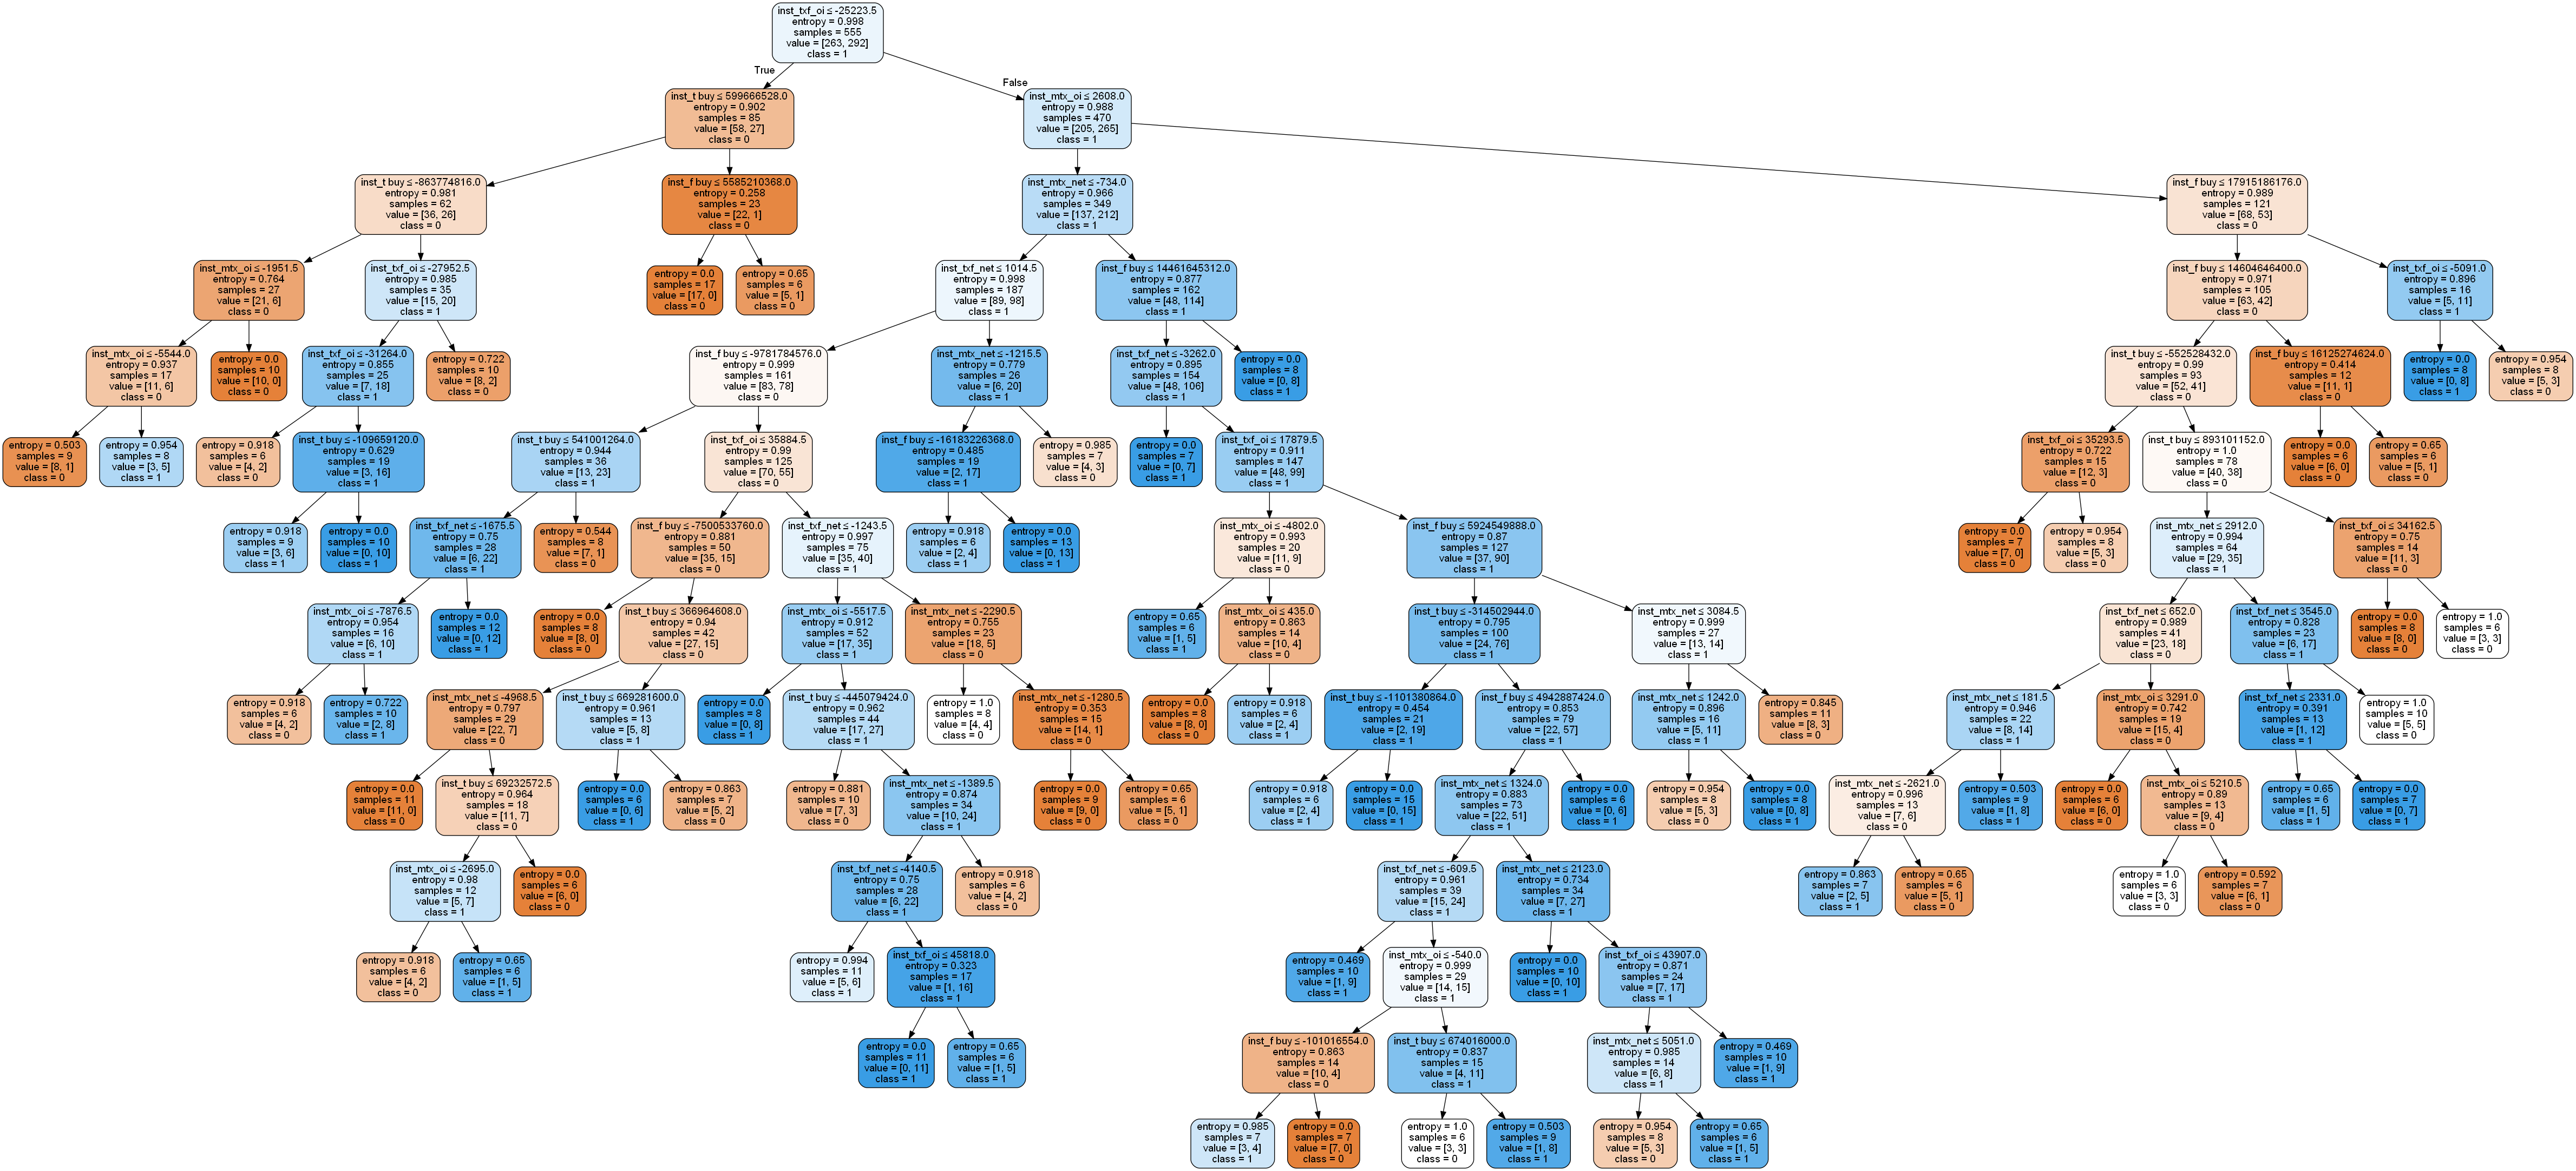

In [18]:
feature_names = df.columns[:6]
dot_data = StringIO()
export_graphviz(
    dtree,
    out_file=dot_data,
    filled=True,
    rounded=True,
    special_characters=True,
    feature_names=feature_names,
    class_names=["0", "1"],
)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png("./tree.png")
Image(graph.create_png())


(-1.0, 6.0)

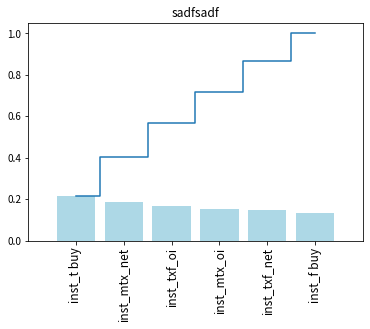

In [19]:
importances = dtree.feature_importances_
feat_names = df.columns[:6]
indices = np.argsort(importances)[::-1]

plt.title("sadfsadf")
plt.bar(range(len(indices)), importances[indices], color="lightblue", align="center")
plt.step(
    range(len(indices)), np.cumsum(importances[indices]), where="mid", label="adfsdf"
)
plt.xticks(range(len(indices)), feat_names[indices], rotation="vertical", fontsize=12)
plt.xlim([-1, len(indices)])


In [20]:
rf = RandomForestClassifier(
    criterion="entropy", n_estimators=3, max_depth=None, min_samples_split=10
)
rf.fit(X_train, y_train)
rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
print(f"隨森AUC = {rf_roc_auc}")
print(classification_report(y_test, rf.predict(X_test)))

隨森AUC = 0.4617430441898527
              precision    recall  f1-score   support

           0       0.43      0.40      0.42        47
           1       0.49      0.52      0.50        52

    accuracy                           0.46        99
   macro avg       0.46      0.46      0.46        99
weighted avg       0.46      0.46      0.46        99



In [21]:
Estimators = rf.estimators_
for index, model in enumerate(Estimators):
    dot_data = StringIO()
    export_graphviz(
        model,
        out_file=dot_data,
        feature_names=df.columns[:6],
        class_names=["0", "1"],
        filled=True,
        rounded=True,
        special_characters=True,
    )
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png(f'./Rf{index}.png')

True

(-0.5, 3935.5, 2798.5, -0.5)

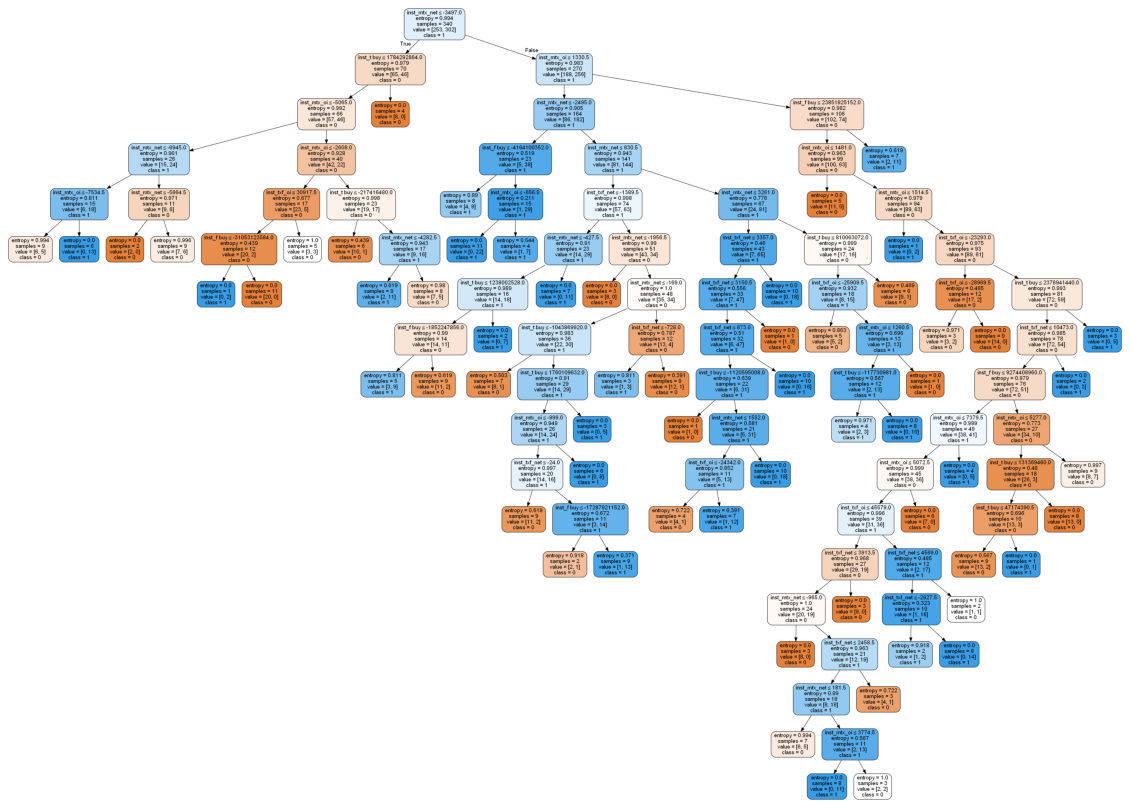

In [28]:
plt.figure(figsize=(20,15))
plt.imshow(plt.imread('./Rf2.png'))
plt.axis('off')

(-1.0, 6.0)

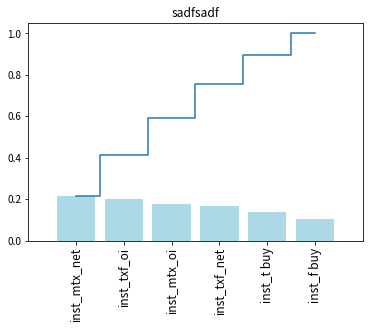

In [29]:
importances = rf.feature_importances_
feat_names = df.columns[:6]
indices = np.argsort(importances)[::-1]

plt.title("sadfsadf")
plt.bar(range(len(indices)), importances[indices], color="lightblue", align="center")
plt.step(
    range(len(indices)), np.cumsum(importances[indices]), where="mid", label="adfsdf"
)
plt.xticks(range(len(indices)), feat_names[indices], rotation="vertical", fontsize=12)
plt.xlim([-1, len(indices)])


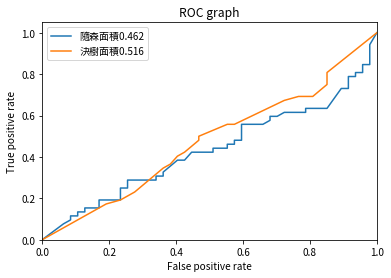

In [30]:
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test,rf.predict_proba(X_test)[:,1])
dt_fpr, dt_tpr, dt_thresholds = roc_curve(y_test, dtree.predict_proba(X_test)[:,1])
plt.plot(rf_fpr, rf_tpr, label=f'隨森面積{rf_roc_auc:.3}')
plt.plot(dt_fpr, dt_tpr, label=f'決樹面積{dt_roc_auc:.3}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC graph')
plt.legend(loc=0)


# 回測
區分做多vs做空，停損設定從20至100，每5點一個區間，看邊際效益最大化落在哪邊

做多停損設20時，交易次數384，停利99次，被停損285次
放空停損設20時，交易次數71，停利23次，被停損48次
做多停損設25時，交易次數384，停利114次，被停損270次
放空停損設25時，交易次數71，停利25次，被停損46次
做多停損設30時，交易次數384，停利132次，被停損252次
放空停損設30時，交易次數71，停利29次，被停損42次
做多停損設35時，交易次數384，停利148次，被停損236次
放空停損設35時，交易次數71，停利31次，被停損40次
做多停損設40時，交易次數384，停利162次，被停損222次
放空停損設40時，交易次數71，停利36次，被停損35次
做多停損設45時，交易次數384，停利181次，被停損203次
放空停損設45時，交易次數71，停利37次，被停損34次
做多停損設50時，交易次數384，停利196次，被停損188次
放空停損設50時，交易次數71，停利39次，被停損32次
做多停損設55時，交易次數384，停利214次，被停損170次
放空停損設55時，交易次數71，停利41次，被停損30次
做多停損設60時，交易次數384，停利226次，被停損158次
放空停損設60時，交易次數71，停利44次，被停損27次
做多停損設65時，交易次數384，停利246次，被停損138次
放空停損設65時，交易次數71，停利46次，被停損25次
做多停損設70時，交易次數384，停利258次，被停損126次
放空停損設70時，交易次數71，停利50次，被停損21次
做多停損設75時，交易次數384，停利267次，被停損117次
放空停損設75時，交易次數71，停利51次，被停損20次
做多停損設80時，交易次數384，停利275次，被停損109次
放空停損設80時，交易次數71，停利52次，被停損19次
做多停損設85時，交易次數384，停利285次，被停損99次
放空停損設85時，交易次數71，停利52次，被停損19次
做多停損設90時，交易次數384，停利291次，被停損93次
放空停損設90時，交易次數71，停利54次，被停損17次
做多停損設95時，交易次數384，停利293次，被停損91次
放空停損設95時，交易次數71，停利54次，被停損17次
做多停損設100時，交易次數384，停利297次，被停損

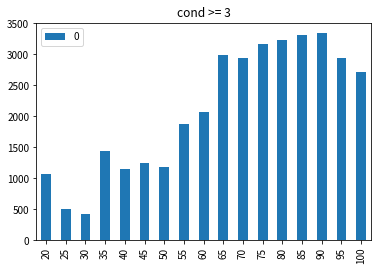

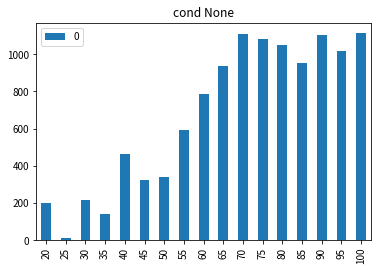

In [31]:
bull_tb, bear_tb = dict(), dict()
for threshold in range(20, 101, 5):
    df = pd.read_csv('./raw_data.csv', index_col = 'date', parse_dates = True)
    cond1 = df['inst_f buy'] > df['inst_f buy'].rolling(5).mean()
    cond2 = df['inst_t buy'] > df['inst_t buy'].rolling(5).mean()
    cond3 = df['inst_txf_net'] > 0
    cond4 = df['inst_txf_oi'] > df['inst_txf_oi'].rolling(5).median()
    cond5 = df['inst_mtx_net'] > 0
    cond6 = (df['inst_mtx_oi'] > df['inst_mtx_oi'].rolling(5).median()) & (df['inst_mtx_oi'] > 0)
    cond7 = df['above_ma'] > df['above_ma'].rolling(5).mean()

    signal = pd.concat([cond1, cond2, cond3, cond4, cond5, cond6, cond7], axis = 1)
    cond = signal[4:-1][signal[4:-1].sum(axis = 1) >= 3].index 

    cond_next = [df[df.index > cond[i]].index[0] for i in range(len(cond))]
    df1 = df[df.index.isin(cond_next)]

    fee = 4
    df1_sl = df1[(df1['txf_open'] - threshold > df1['txf_low'])] 
    sl = len(df1_sl) * (-threshold - fee) # 直接求出值了，不是LIST
    df1_tp = df1[~(df1['txf_open'] - threshold > df1['txf_low'])]    
    tp = df1_tp['txf_close'] - df1_tp['txf_open'] - fee
    print(f'做多停損設{threshold}時，交易次數{len(df1)}，停利{len(df1_tp)}次，被停損{len(df1_sl)}次')
    log_long = {threshold : [sum(tp) + sl]}
    bull_tb.update(log_long)

    cond = df[~(cond1 | cond2 | cond3 | cond4 | cond5 | cond6 | cond7)].index
    cond_next = [df[df.index > cond[i]].index[0] for i in range(len(cond))]
    df1 = df[df.index.isin(cond_next)]

    df1_sl = df1[(df1['txf_open'] + threshold < df1['txf_high'])] 
    sl = len(df1_sl) * (-threshold - 4)
    df1_tp = df1[~(df1['txf_open'] + threshold < df1['txf_high'])]
    tp = df1_tp['txf_open'] - df1_tp['txf_close'] - 4
    print(f'放空停損設{threshold}時，交易次數{len(df1)}，停利{len(df1_tp)}次，被停損{len(df1_sl)}次')
    log_short = {threshold : [sum(tp) + sl]}
    bear_tb.update(log_short)

pd.DataFrame(bull_tb.values(), index = bull_tb.keys()).plot(kind = 'bar', title = 'cond >= 3')
pd.DataFrame(bear_tb.values(), index = bear_tb.keys()).plot(kind = 'bar', title = 'cond None')